<a href="https://colab.research.google.com/github/hirokimituya/stock-price-analysis/blob/main/technical_analysis/%E6%A0%AA%E4%BE%A1%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas_datareader.data as pdr

# 株価データを取得するメソッド
def get_stock_data(code):
    df = pdr.DataReader(f'{code}.JP', 'stooq').sort_index()
    return df

<Axes: xlabel='Date'>

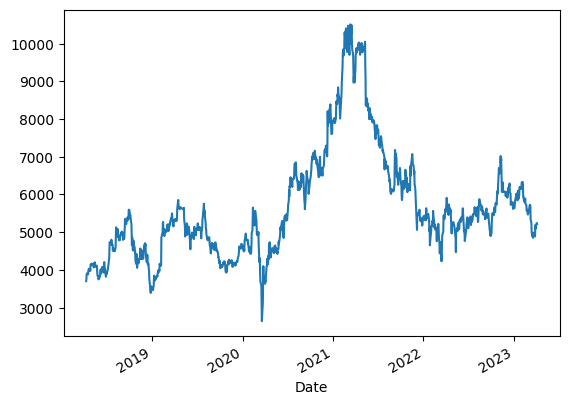

In [2]:
#　ソフトバンクの株価データ取得
df = get_stock_data(9984)
df['Close'].plot()

<Axes: xlabel='Date'>

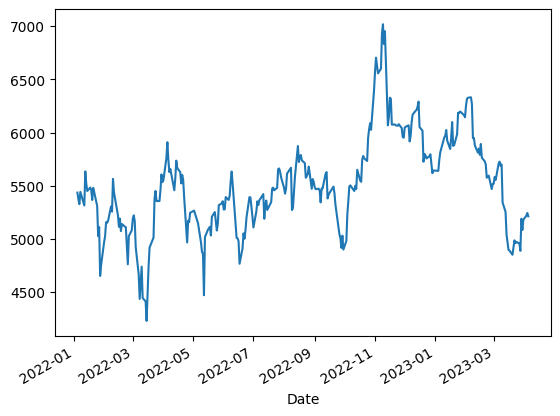

In [4]:
import datetime as dt
df[df.index >= dt.datetime(2022, 1, 1)]['Close'].plot()

### 高値と安値で差が大きいデータが多いほど、短期間での売買で利益を出しやすい銘柄であると判断できる


In [7]:
# 高値と安値の差が300円以上の株価データ
df.query('High - Low >= 300').tail()

,Open,High,Low,Close,Volume
Date,,,,,
2022-11-08,6655.0,6997.0,6650.0,6929.0,33680300.0
2022-11-14,6353.0,6453.0,5956.0,6068.0,40860800.0
2022-11-16,6090.0,6400.0,6090.0,6328.0,32497500.0
2022-11-18,6355.0,6363.0,6044.0,6075.0,25586100.0
2022-12-20,6038.0,6041.0,5715.0,5726.0,16122200.0
